## Imports

In [1]:
import torch
import torchvision

from torch.utils.data import DataLoader, Dataset

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os



In [2]:
## Setting torch seed

random_seed = 1
torch.manual_seed(random_seed)

## Data Loaders and MINST DataSet

In [3]:
#Loaders Parameters
batch_size_train = 64
batch_size_test = 1000

path = "handwritten-digits-recognizer/"

transform = torchvision.transforms.Compose([ torchvision.transforms.ToTensor() ])

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(path, train=True, download=True, transform=transform),
  batch_size=batch_size_train,shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(path, train=False, download=True, transform=transform),
  batch_size=batch_size_test, shuffle=True)


### Examples

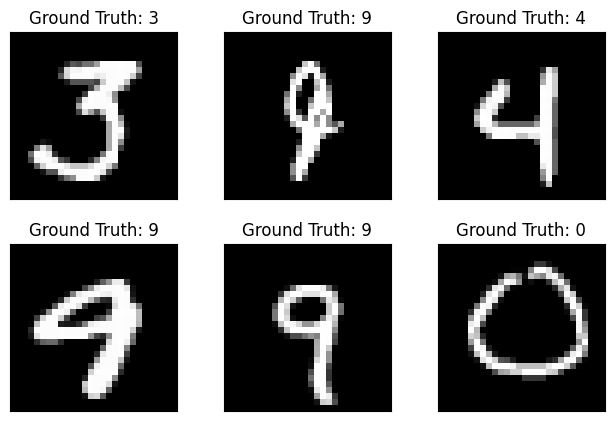

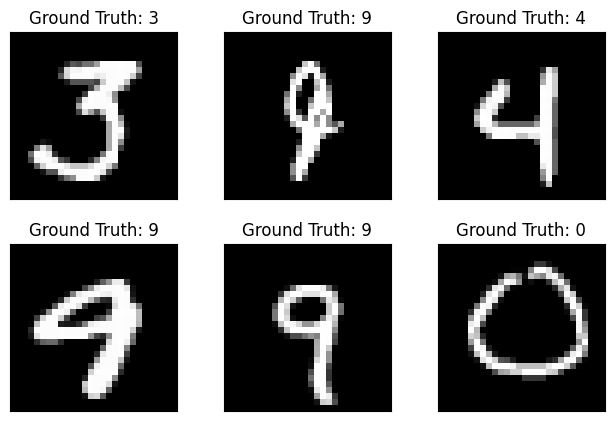

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)



fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

## Model Architecture

In [5]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


/home/franio/Desktop/handwritten-digits-recognizer/venv/lib/python3.11/site-packages/torch/nn/functional.py:1542: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


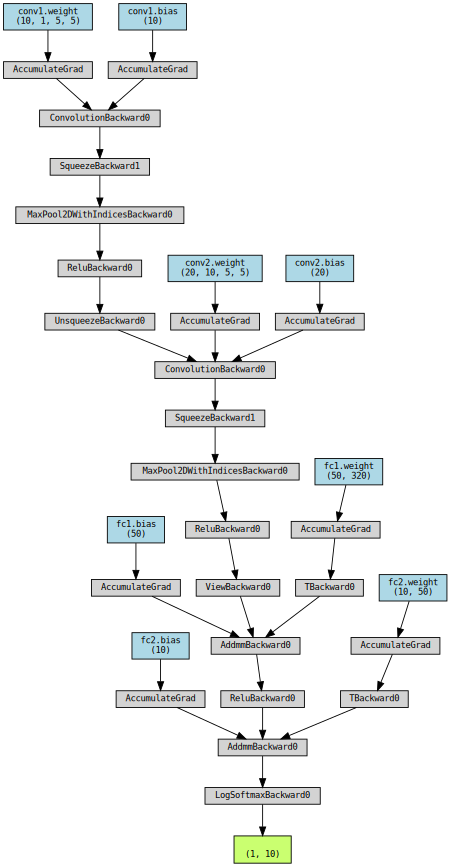

In [6]:
from torchviz import make_dot


model = MyModel()
dummy = torch.unsqueeze(torch.rand((28,28)), 0)

model.eval()
output = model(dummy)

dot = make_dot(output, params=dict(model.named_parameters()), show_attrs=False)

dot

## Training the model

=========== Epoch 1 ===========
=========== Epoch 2 ===========
=========== Epoch 3 ===========


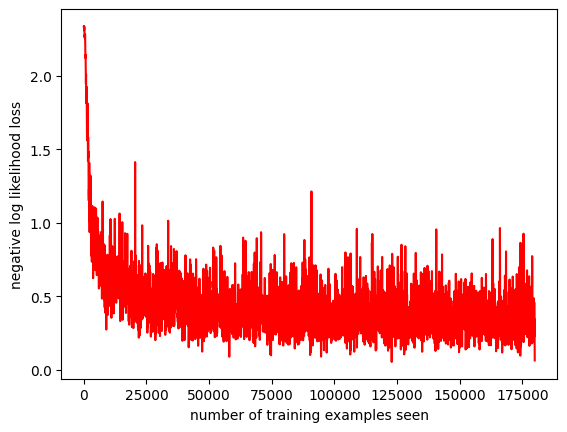

In [7]:



#Hyperparameters
n_epochs = 3
learning_rate = 0.01

model = MyModel()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()


train_losses = []
train_counter = []

for epoch in range(n_epochs):
    model.train()
    print(f"=========== Epoch {epoch + 1} ===========")
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        
        loss = criterion(output, target)
        train_losses.append(loss.item())
        train_counter.append((batch_idx*64) + ((epoch)*len(train_loader.dataset)))

        loss.backward()
        optimizer.step()


plt.plot(train_counter, train_losses, color='red')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()

## Saving a model


In [8]:
torch.save(model.state_dict(), "model.pth")

## Testing a model


[4.9415472e-09 1.9103508e-12 9.9998122e-01 5.9613462e-06 3.1742304e-12
 6.8859916e-15 2.8921408e-14 1.2464638e-05 3.7522744e-07 5.3481555e-12]
[3.5534850e-08 1.1688745e-07 9.9956250e-01 3.4878387e-05 1.7684372e-09
 1.2349254e-10 1.4921324e-10 1.4020967e-04 2.6215581e-04 5.2021420e-08]
[1.5214349e-13 7.0995569e-17 2.1220939e-15 8.5325453e-09 1.4318319e-09
 9.9999768e-01 5.1648328e-07 1.6580487e-16 1.1268194e-06 6.6901481e-07]
[1.7744571e-10 3.6048722e-10 2.4105786e-09 1.0828627e-09 8.4365848e-12
 8.3488476e-06 2.9745632e-08 4.1401916e-15 9.9999166e-01 1.8693842e-10]
[6.6478725e-07 2.4159850e-05 1.5611117e-04 3.0731437e-05 1.2034322e-06
 2.9402087e-04 2.9874871e-06 7.2538217e-07 9.9948597e-01 3.3552276e-06]
[2.0672327e-07 3.6638448e-12 1.8431095e-11 2.1851770e-14 3.3276044e-09
 2.8288250e-06 9.9999660e-01 4.2810841e-19 2.7594388e-07 1.2051304e-16]
[4.8595034e-06 2.6874325e-06 7.0268752e-06 2.2991653e-06 2.9610271e-07
 3.3404742e-04 2.3406360e-06 8.5577598e-09 9.9963069e-01 1.5745212e-05]

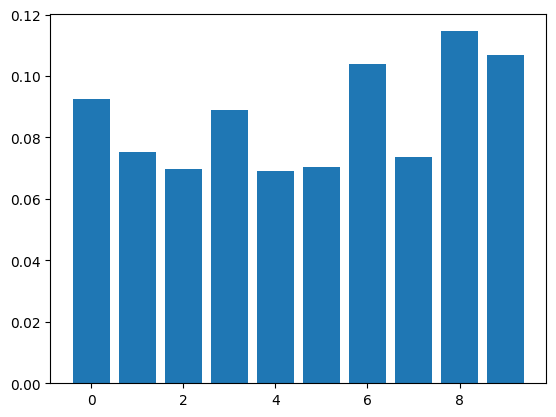

In [9]:
test_losses = []

test_loss = 0
correct = 0

model.eval()
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        print(np.exp(output.numpy()[0]))
        
        test_loss += criterion(output, target).item()
        pred = output.data.max(1, keepdim=True)[1]
        
        correct += pred.eq(target.data.view_as(pred)).sum()
        
        test_losses.append(criterion(output, target).item())
        
    test_loss /= len(test_loader.dataset)
    
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))


counter = np.arange(len(test_losses))
plt.bar(counter, test_losses)
plt.show()